# ReLu ResNets Singular points
Characterizing ResNets with 2d input and no bottle neck
How is the necessary singular point realized?

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.colors import to_rgb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split

from models.training import make_circles_uniform



In [ ]:
# Model Params
num_hidden = 4 # number of hidden layers. The total network has additionl 2 layers: input to hidden + hidden to output
input_dim = 2
hidden_dim = 2
output_dim = 1
activation = 'relu' #tanh also included 


#load or train
# load_file = 'resnet_5_CE' #set to False for training
# load_file = 'resnet_7_MSE'
load_file = 'relu_4_2dMSE'
# load_file = 'last'

# Training Params
cross_entropy = True #MSE loss leads to worse results for the architecture with 5 layers. at the moment the fewer layers the better thats why CE is chosen
num_epochs = 400
batch_size = 128

23


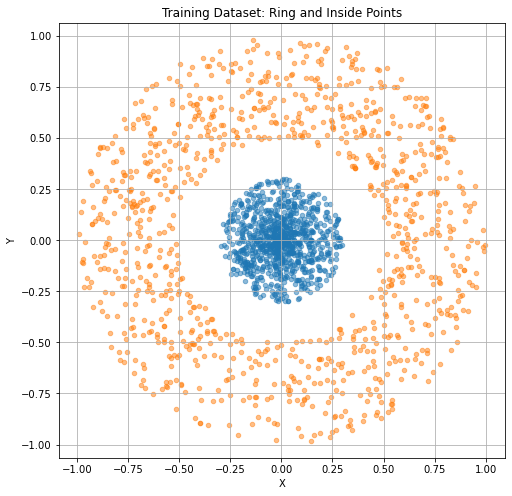

In [ ]:
def make_circles_uniform(n_samples = 2000, inner_radius = 0.5, buffer = 0.2, outer_radius = 1.0, cross_entropy = cross_entropy, output_dim = 2, plot = True, batch_size = batch_size, filename = None):
    """Generates a dataset of points in a ring and inside the ring.
    Args:   
        n_samples (int): Total number of samples to generate.
        inner_radius (float): Radius of the inner RING line.
        outer_radius (float): Radius of the outer RING line.
        buffer (float): Buffer between ring and circle.
        cross_entropy (bool): If True, use cross-entropy loss. If False, use MSE loss.
        output_dim (int): Dimension of the output labels. MSE allows 2d
    """
    # Generate training data
    # set random seed for reproducibility
    seed = np.random.randint(1000)
    print(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Generate outer ring points
    n_points = n_samples // 2
    inner_radius = inner_radius #of outer ring
    outer_radius = outer_radius #of outer ring

    # Buffer between inner and outer ring
    buffer = buffer

    # Points on ring
    angles_ring = np.random.uniform(0, 2 * np.pi, n_points)
    radius_ring = np.random.uniform(inner_radius, outer_radius, n_points)
    x_ring = radius_ring * np.cos(angles_ring)
    y_ring = radius_ring * np.sin(angles_ring)
    ring_points = np.stack((x_ring, y_ring), axis=1)

    # Points inside ring
    angles_inside = np.random.uniform(0, 2 * np.pi, n_points)
    radius_inside = inner_radius * np.sqrt(np.random.uniform(0, 1, n_points))
    x_inside = (radius_inside-buffer) * np.cos(angles_inside)
    y_inside = (radius_inside-buffer) * np.sin(angles_inside)
    inside_points = np.stack((x_inside, y_inside), axis=1)

    # Labels
    if cross_entropy:
        labels_ring = np.ones((n_points), dtype=np.int64)
        labels_inside = np.zeros((n_points), dtype=np.int64)    
    if output_dim == 2:
        labels_ring = np.tile([1, 0], (n_points, 1))
        labels_inside = np.tile([-1, 0], (n_points, 1))
    if output_dim == 1:
        labels_ring = np.ones((n_points, 1))
        labels_inside = -np.ones((n_points, 1))

    # Combine data
    data = np.vstack((ring_points, inside_points))
    labels = np.vstack((labels_ring, labels_inside))

    # Convert to tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)

    if cross_entropy:
        labels = np.concatenate((labels_ring, labels_inside))
        labels_tensor = torch.tensor(labels, dtype=torch.long)
        print(labels_tensor[:1])
    else:
        labels = np.vstack((labels_ring, labels_inside))
        labels_tensor = torch.tensor(labels, dtype=torch.float32)
    
    if plot:
        # Plot the data
        plt.figure(figsize=(8, 8))
        plt.scatter(ring_points[:, 0], ring_points[:, 1], s=20, c='C1', alpha = 0.5, label='Ring Points')
        plt.scatter(inside_points[:, 0], inside_points[:, 1], s=20, c='C0', alpha = 0.5, label='Inside Points')
        plt.xlabel('X')
        plt.ylabel('Y')
        # plt.legend()
        plt.title('Training Dataset: Ring and Inside Points')
        plt.axis('equal')
        plt.grid(True)
        
                # Save plot if filename provided
        if filename is not None:
            plt.savefig(f'{filename}.png', bbox_inches='tight', dpi=300)
            print(f'Plot saved as {filename}.png')
        
        plt.show()
    
    # Create DataLoader
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    
    if output_dim == 1:
        y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
        y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)
    else:
        y_train = torch.tensor(y_train, dtype=torch.float32)  # Don't reshape for 2D outputs
        y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader for training data
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    # Create DataLoader for training data
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = make_circles_uniform(n_samples = 2000, inner_radius = 0.5, buffer = 0.2, outer_radius = 1.0)


In [21]:
for data, label in train_dataloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([20, 2])
torch.Size([20, 2])


# Initialize model, optimizer, and loss function


In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, features, activation = 'relu'):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(features, features)
        if activation == 'relu':
            self.activation = nn.ReLU()
        if activation == 'tanh':
            self.activation = nn.Tanh()

    def forward(self, x):
        identity = x #cont here
        out = self.fc(x)
        out = self.activation(out)
        out = out + identity
        return out

class ResNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden, output_layer = True, activation = 'relu'):
        super(ResNet, self).__init__()
        self.num_hidden = num_hidden
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        if activation == 'relu':
            self.activation = nn.ReLU()
        if activation == 'tanh':
            self.activation = nn.Tanh()
            
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(hidden_dim, activation = activation) for _ in range(num_hidden)]
        )
        self.output_fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, output_layer = True):
        x = self.activation(self.input_fc(x))
        x = self.res_blocks(x)
        if output_layer:
            x = self.output_fc(x)
        return x
    
    '''
    sub_model is used to access a partial network of the input to output network
    layers are counted from 0 (input to hidden dim) until nth layer ( (n-1)th hidden layer to output layer)
    from_layer is the starting layer that is included in the sub_model
    to_layer is the final layer included in the sub_model
    e.g. from_layer = 1, to_layer = 2 includes the first two ResBlocks
    initial layer is counted as layer 0
    hidden to output layer is counted as final layer
    '''
    def sub_model(self, x, from_layer, to_layer):
        if to_layer > self.num_hidden + 1:
            print('Error: to_layer is larger than existing number of layers')
            return
        if from_layer > to_layer:
            print('Error: to_layer cannot be larger than from_layer')
        
        
        if from_layer == 0:
            x = self.activation(self.input_fc(x))
            from_layer += 1 #if from_layer = 0 I need to increase the from_layer count

        if to_layer > 0 and from_layer < self.num_hidden + 1:
            reduced_block = self.res_blocks[from_layer - 1 : to_layer] #from layer 1 to 2 means hidden layer 0 to hidden layer 1
            x = reduced_block(x)
        if to_layer == self.num_hidden + 1:
            x = self.output_fc(x)
        return x
            
# test_model = ResNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_hidden=num_hidden)

# for l in range(0,10):
#     print(l)
#     test = test_model.sub_model(torch.tensor([1.,1.]), to_layer = l, from_layer = 1)
#     print(test)
#     test2 = test_model.sub_model(torch.tensor([1.,1.]), to_layer = l, from_layer = l)
#     print(test2)
    



--- Loading Checkpoint from: relu_4_2dMSE.pth ---
Model state loaded successfully.
Loaded training losses (Length: 400).
Original training seed: 853
Model trained for 400 epochs.
Saved Hyperparameters: Input=2, Hidden=2, Output=2, Blocks=4, CrossEntropy=False


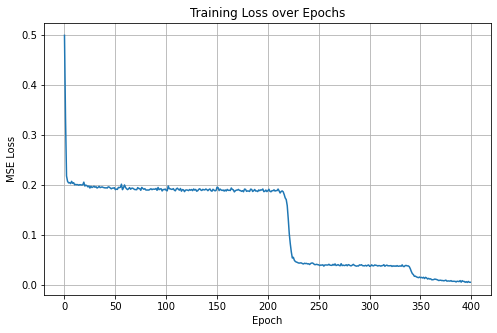

In [14]:
target_loss = 0.05
final_loss = float('inf')
attempt = 0
max_attempts = 10  # To avoid infinite loops

if 'load_file' not in locals():  # Only enter retry loop if no model is being loaded
    while final_loss > target_loss and attempt < max_attempts:
        attempt += 1
        print(f"\n--- Training Attempt {attempt} ---")

        model = ResNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim,
                       num_hidden=num_hidden, activation=activation)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss() if cross_entropy else nn.MSELoss()
        print(criterion)
        losses = []

        for epoch in range(num_epochs):
            epoch_loss = 0
            for inputs, targets in dataloader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            avg_epoch_loss = epoch_loss / len(dataloader)
            if (epoch + 1) % 20 == 0 or epoch == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')
            losses.append(avg_epoch_loss)

        final_loss = losses[-1]
        print(f"Final loss after attempt {attempt}: {final_loss:.4f}")

    # Only save checkpoint if target loss achieved
    if final_loss <= target_loss:
        print(f"\n✅ Training completed successfully with final loss: {final_loss:.4f}")
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': losses,
            'seed': seed,
            'epoch': epoch,
            'input_dim': input_dim,
            'hidden_dim': hidden_dim,
            'output_dim': output_dim,
            'num_blocks': num_hidden,
            'cross_entropy': cross_entropy
        }
        save_path = f'last.pth'
        torch.save(checkpoint, save_path)
        print(f'Checkpoint saved to {save_path}')
    else:
        print(f"\n❌ Max attempts reached. Best final loss: {final_loss:.4f}")
else:
    load_file = load_file + '.pth'
    model = ResNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim,
                num_hidden=num_hidden, activation=activation)
    try:
        print(f"--- Loading Checkpoint from: {load_file} ---")
        checkpoint = torch.load(load_file)
        model.load_state_dict(checkpoint['model_state_dict'])

        losses = checkpoint.get('losses', [])
        loaded_seed = checkpoint.get('seed', 'Not Found')
        last_epoch = checkpoint.get('epoch', 'Not Found')
        loaded_input_dim = checkpoint.get('input_dim', 'Not Found')
        loaded_hidden_dim = checkpoint.get('hidden_dim', 'Not Found')
        loaded_output_dim = checkpoint.get('output_dim', 'Not Found')
        loaded_num_blocks = checkpoint.get('num_blocks', 'Not Found')
        loaded_cross_entropy = checkpoint.get('cross_entropy', 'Not Found')

        # Check if loaded hyperparameters match the current ones
        assert loaded_input_dim == input_dim, f"Mismatch: loaded_input_dim={loaded_input_dim}, expected={input_dim}"
        assert loaded_hidden_dim == hidden_dim, f"Mismatch: loaded_hidden_dim={loaded_hidden_dim}, expected={hidden_dim}"
        assert loaded_output_dim == output_dim, f"Mismatch: loaded_output_dim={loaded_output_dim}, expected={output_dim}"
        assert loaded_num_blocks == num_hidden, f"Mismatch: loaded_num_blocks={loaded_num_blocks}, expected={num_hidden}"
        assert loaded_cross_entropy == cross_entropy, f"Mismatch: loaded_cross_entropy={loaded_cross_entropy}, expected={cross_entropy}"

        print(f"Model state loaded successfully.")
        print(f"Loaded training losses (Length: {len(losses)}).")
        print(f"Original training seed: {loaded_seed}")
        print(f"Model trained for {last_epoch + 1 if isinstance(last_epoch, int) else 'N/A'} epochs.")
        print(f"Saved Hyperparameters: Input={loaded_input_dim}, Hidden={loaded_hidden_dim}, Output={loaded_output_dim}, Blocks={loaded_num_blocks}, CrossEntropy={loaded_cross_entropy}")
        model.eval()

    except AssertionError as e:
        print(f"Error: {e}")
        print("Loaded checkpoint hyperparameters do not match the current configuration.")
    except FileNotFoundError:
        print(f"Error: Checkpoint file not found at {load_file}")
        losses = []

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()


In [15]:
model.parameters

<bound method Module.parameters of ResNet(
  (input_fc): Linear(in_features=2, out_features=2, bias=True)
  (activation): ReLU()
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (activation): ReLU()
    )
    (1): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (activation): ReLU()
    )
    (2): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (activation): ReLU()
    )
    (3): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (activation): ReLU()
    )
  )
  (output_fc): Linear(in_features=2, out_features=2, bias=True)
)>

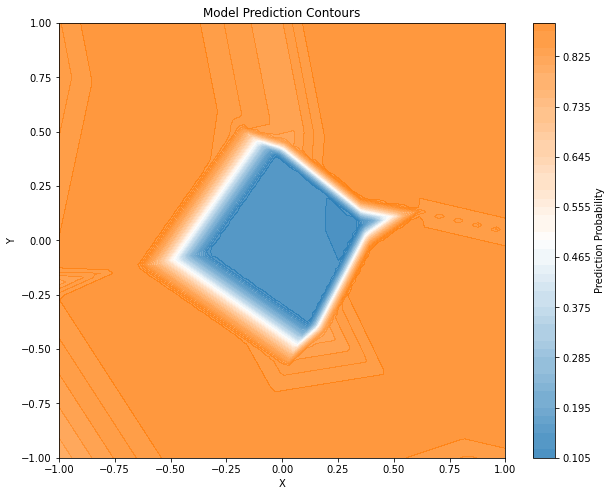

In [16]:
# Plot prediction contours
xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    preds = model(grid)  # shape: (10000, 2)
    
    # Distance to each label vector
    dist_to_class1 = torch.norm(preds - torch.tensor([1.0, 0.0]), dim=1)
    dist_to_class2 = torch.norm(preds - torch.tensor([-1.0, 0.0]), dim=1)

    # Turn distance into "confidence"
    scores = torch.stack([-dist_to_class1, -dist_to_class2], dim=1)  # negative = closer is better
    probs = torch.softmax(scores, dim=1)

    zz = probs[:, 0].reshape(xx.shape).numpy()  # confidence of being class [1, 0]


colors = [to_rgb("C0"), [1, 1, 1], to_rgb("C1")] # first color is orange, last is blue
cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, zz, levels=50, cmap=cm, alpha=0.8)
plt.colorbar(label='Prediction Probability')
plt.xlabel('X')
plt.ylabel('Y')
# plt.scatter(ring_points[:500, 0], ring_points[:500, 1], s=25, facecolors='C1', edgecolors='black', linewidths=0.5, alpha=0.5)
# plt.scatter(inside_points[:500, 0], inside_points[:500, 1], s=25, c='C0',  edgecolors='black', linewidths=0.5, alpha=0.5,  label='Inside Points')
plt.title('Model Prediction Contours')
# plt.axis('equal')
plt.grid(False)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('tight')
plt.show()


# Singular value computations and plotting
We want to determine singular points in the compact space

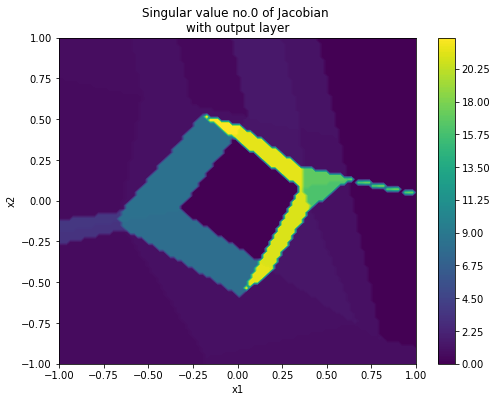

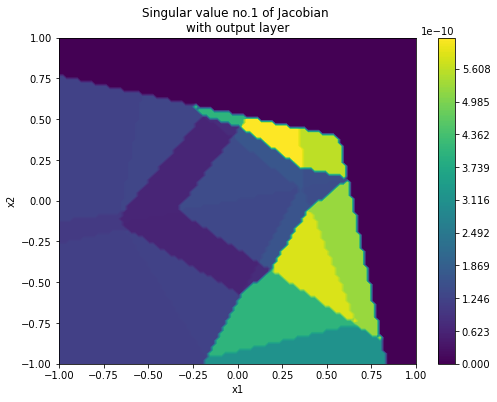

In [17]:
# Define a grid over the input space.
grid_size = 200 # Adjust as needed.

def psi_manual(x, func):
    """
    x: a tensor of shape (2,) representing a point in R^2.
    model: a function mapping R^2 to R^2.
    
    Returns:
      The smallest singular value of the Jacobian of model at x.
    """
    # Ensure x is a leaf variable with gradient tracking enabled.
    x = x.clone().detach().requires_grad_(True)
    
    # Define a lambda function to ensure accurate input-output mapping
    # func = lambda inp: model(inp, output_layer = False)
    
    # Compute the Jacobian using torch.autograd.functional.jacobian (compatible with Python 3.8)
    jacobian = torch.autograd.functional.jacobian(func, x, create_graph=True)
    
    # Compute singular values using svdvals (available in PyTorch 1.8, compatible with Python 3.8)
    singular_values = torch.svd(jacobian, compute_uv=False)[1]
    
   
    return singular_values.detach().numpy()


def sv_plot(func, sv_index = 0, x_range = [-1,1], y_range = [-1,1], grid_size = 100, ax = None, title = ''):
  x_values = np.linspace(x_range[0], x_range[1], grid_size)
  y_values = np.linspace(y_range[0], y_range[1], grid_size)
  psi_values = np.zeros((grid_size, grid_size, 2))
  
  # Evaluate psi(x) over the grid.
  for i, xv in enumerate(x_values):
      for j, yv in enumerate(y_values):
          # Create a 2D point as a torch tensor.
          x_point = torch.tensor([xv, yv], dtype=torch.float32)
          psi_values[j, i,:] = psi_manual(x_point, func) #one subtlety here: if there is only one SV it gets broadcast to all dimensions of psi_values[j,i,:] in the last dimension. this reduces if statements for e.g. the last layer, but we need to notice that the SINGLE SV gets plotted twice  
   

  # Here we plot the contour at a small level, e.g., 0.01.
  # CS = plt.contour(x_range, y_range, psi_values, levels=[0,0.05,0.1,0.2,0.3], colors='red')

  # Define the number of levels for the contour plot
  vmin1, vmax1 = psi_values[:, :, sv_index].min(), psi_values[:, :, sv_index].max()
  num_levels = 200

  levels = np.linspace(0, vmax1, num_levels)
  
  # Plot on the provided axis
  if ax is not None:
      cs = ax.contourf(x_values, y_values, psi_values[:, :, sv_index], levels=levels, cmap='viridis')
      ax.set_title(title)
      ax.set_xlabel('x1')
      ax.set_ylabel('x2')
      ax.set_aspect('equal')
      return cs
  else:
    # Create the contour plot using the 'binary' colormap
    plt.figure(figsize=(8, 6))
    
    CS = plt.contourf(x_values, y_values, psi_values[:,:,sv_index], levels=levels, cmap = 'viridis')
    cbar = plt.colorbar(CS)
    plt.title(f'Singular value no.{sv_index} of Jacobian \nwith output layer')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()



        
# Put the model in evaluation mode.
model.eval()
func = lambda inp: model(inp, output_layer = True)
sv_plot(func, sv_index = 0, title = f'Singular value no.0 of Jacobian \nwith output layer')
sv_plot(func, sv_index = 1, title = f'Singular value no.1 of Jacobian \nwith output layer')

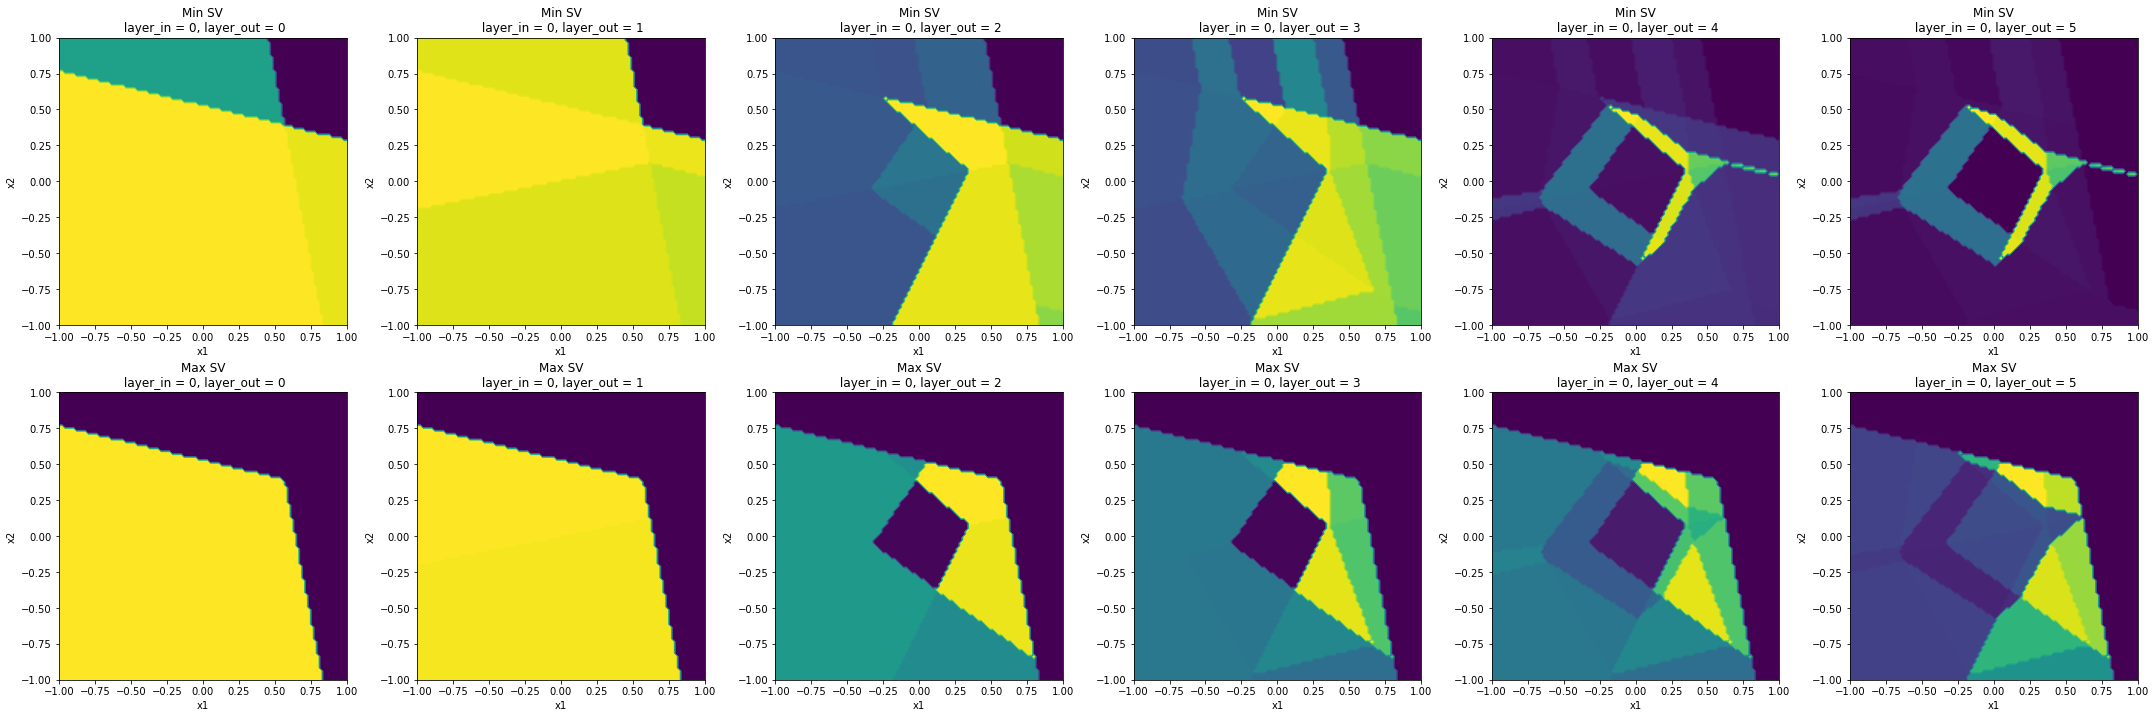

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Put the model in evaluation mode.
model.eval()

# Prepare figure and axes
fig, axes = plt.subplots(2, num_hidden + 2, figsize=(5 * (num_hidden + 2), 10))  # Adjust figsize if needed

for layer in range(num_hidden + 2):
    func = lambda inp: model.sub_model(inp, from_layer=0, to_layer = layer)

    
    ax = axes[0, layer] if num_hidden > 1 else axes[0]
    cs = sv_plot(func, sv_index = 0, ax = ax, grid_size=100)
    # fig.colorbar(cs, ax=ax)
    ax.set_title(f'Min SV\n layer_in = 0, layer_out = {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')
    
    

    # Plot largest singular value (index 0) - second row
    ax = axes[1, layer] if num_hidden > 1 else axes[1]
    cs = sv_plot(func, sv_index = 1, ax = ax, grid_size=100)
    # fig.colorbar(cs, ax=ax)
    ax.set_title(f'Max SV\n layer_in = 0, layer_out = {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


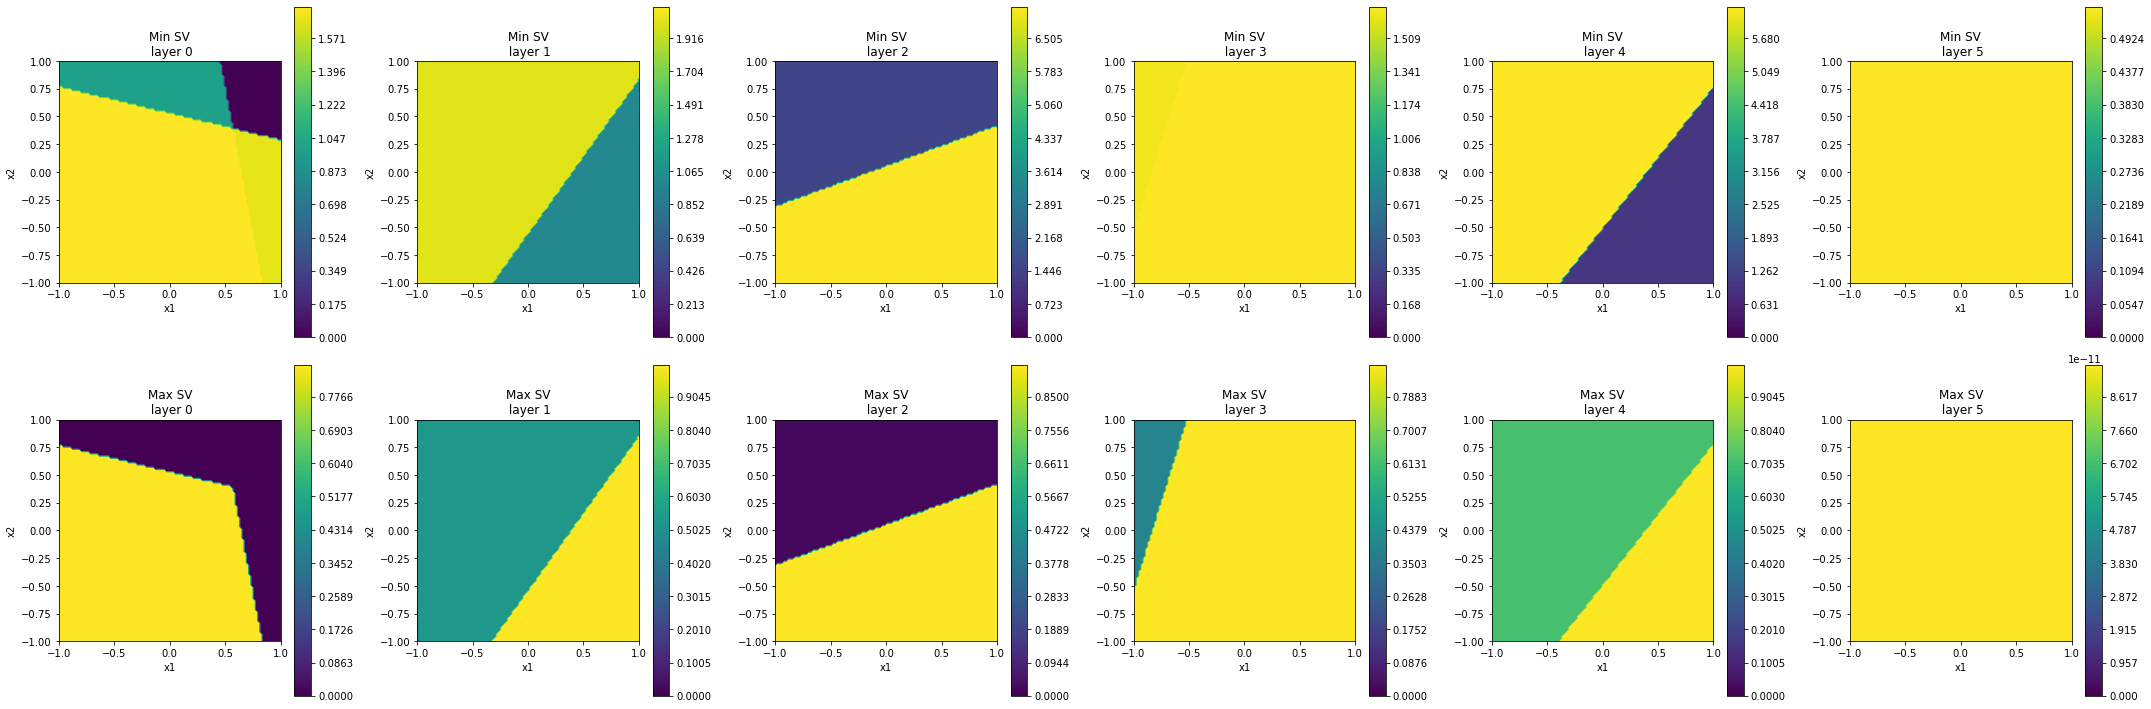

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Put the model in evaluation mode.
model.eval()

# Prepare figure and axes
fig, axes = plt.subplots(2, num_hidden + 2, figsize=(5 * (num_hidden + 2), 10))  # Adjust figsize if needed

for layer in range(num_hidden + 2):
    func = lambda inp: model.sub_model(inp, from_layer = layer, to_layer=layer)

    
    ax = axes[0, layer] if num_hidden > 1 else axes[0]
    cs = sv_plot(func, sv_index= 0 , ax = ax, grid_size=100)
    fig.colorbar(cs, ax=ax)
    ax.set_title(f'Min SV\n layer {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')
    

    # Plot largest singular value (index 0) - second row
    ax = axes[1, layer] if num_hidden > 1 else axes[1]
    cs = sv_plot(func, sv_index=1, ax = ax, grid_size=100)
    fig.colorbar(cs, ax=ax)
    ax.set_title(f'Max SV\n layer {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()
